<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


## Imports

In [1]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os

import random
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
!pwd

/content


## Data preparation

In the hyperparemeter tuning notebook, it is explained with more detailed why I chose this preprocessing steps. I realised that some images contained white squares that were spoiling the generation of new hands, therefore, I decided to delete those images (which only constitute the 5% of the dataset) by retrieving the number of black pixels in each image.

I found that a threshold of 0.5 was ideal.

In [5]:
def contains_few_black_pixels(image, threshold):
    """
    Determine if the given image contains a low proportion of black pixels.

    This function calculates the ratio of black pixels in the image and compares
    it with the specified threshold.A pixel is considered black if its intensity
    is below a certain level, determined by the product of 255 and the threshold
    value.

    Parameters
    ----------
    image : numpy.ndarray
        The input image as a NumPy array. It should be a grayscale image where
        pixel values range from 0 (black) to 255 (white).

    threshold : float
        A value between 0 and 1 representing the threshold ratio. The function
        checks if the ratio of black pixels to the total number of pixels in the
         image is less than this threshold value.

    Returns
    -------
    bool
        Returns True if the ratio of black pixels in the image is less than the
        threshold value, indicating that the image contains few black pixels.
        Returns False otherwise.
    """

    black_pixels = np.sum(image < (255 * threshold))


    black_pixel_ratio = black_pixels / image.size


    return black_pixel_ratio < threshold


In [6]:
class HandXRayDataset(Dataset):
    def __init__(self, directory, transform=None, filter_images=True, black_pixel_threshold=0.5):
        self.directory = directory
        self.transform = transform
        self.file_names = []

        for file_name in os.listdir(directory):
            img_path = os.path.join(directory, file_name)
            image = Image.open(img_path).convert('L')
            image_array = np.array(image)

            # Filter images based on the number of black pixels
            if not filter_images or not contains_few_black_pixels(image_array, black_pixel_threshold):
                self.file_names.append(file_name)

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.file_names[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])


dataset = HandXRayDataset(
    'gdrive/My Drive/dlmodule-coursework-1-edsml-jv323/real_hands',
    transform=transform,
    filter_images=True,
    black_pixel_threshold=0.5
)

In [8]:
len(dataset)

7613

We can see some of the images

Image 0: Shape - torch.Size([1, 32, 32])


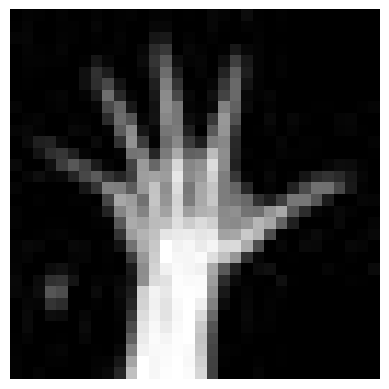

Image 1: Shape - torch.Size([1, 32, 32])


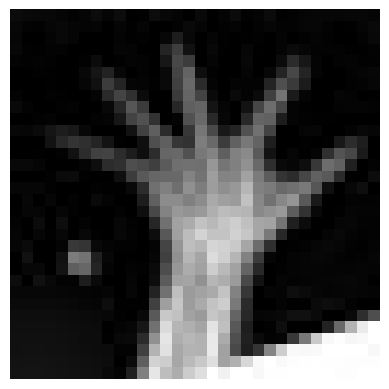

Image 2: Shape - torch.Size([1, 32, 32])


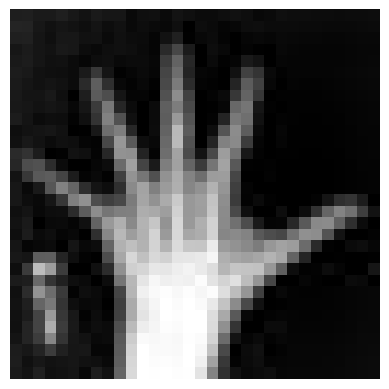

Image 3: Shape - torch.Size([1, 32, 32])


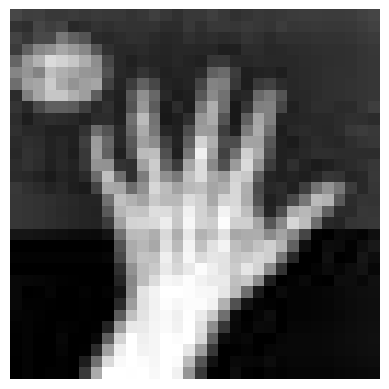

Image 4: Shape - torch.Size([1, 32, 32])


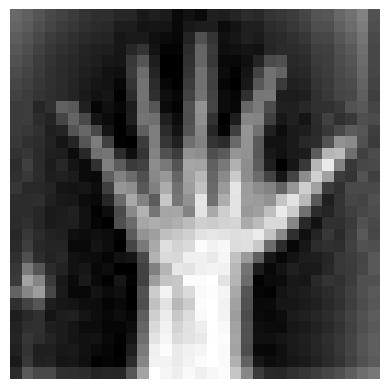

In [9]:
import matplotlib.pyplot as plt

def show_image(image_tensor):

    image = image_tensor.numpy().transpose(1, 2, 0) #match matplotlib notation
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

for i in range(5):
    image_tensor = dataset[i]
    print(f"Image {i}: Shape - {image_tensor.size()}")  #shape of the images
    show_image(image_tensor)

In [10]:
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

## Network design and implementation

I explain why I chose this architecture in the other notebook, as well, as some of the hyperparameters.

In [11]:
class Generator7(nn.Module):
    def __init__(self, latent_dim):
        super(Generator7, self).__init__()
        self.model = nn.Sequential(

            nn.ConvTranspose2d(latent_dim, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Upsample to 8x8
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Upsample to 16x16
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            # Upsample to 32x32
            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)



class Discriminator7(nn.Module):
    def __init__(self):
        super(Discriminator7, self).__init__()
        self.model = nn.Sequential(
            # Input is a 1x32x32 image
            nn.Conv2d(1, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsample to 16x16
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsample to 8x8
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Output layer
            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img).view(-1, 1).squeeze(1)

G7 = Generator7(50).to(device)
D7 = Discriminator7().to(device)

## Training and evaluation loops

In [12]:
def D7_train(x):
    current_batch_size = x.size(0)  # Get the actual size of the batch

    D7.zero_grad()

    # Train with real images
    real_data = x.to(device)
    real_labels = torch.ones(current_batch_size, 1).to(device)  # Adjust label size
    output = D7(real_data).view(-1, 1)
    D7_real_loss = criterion(output, real_labels)

    # Train with fake images
    noise = torch.randn(current_batch_size, z_dim, 1, 1).to(device)  # Adjust noise size
    fake_data = G7(noise)
    fake_labels = torch.zeros(current_batch_size, 1).to(device)  # Adjust label size
    output = D7(fake_data.detach()).view(-1, 1)
    D7_fake_loss = criterion(output, fake_labels)

    # Combine losses and perform backpropagation
    D7_loss = D7_real_loss + D7_fake_loss
    D7_loss.backward()
    D7_optimizer.step()

    return D7_loss.item()

In [13]:
def G7_train(current_batch_size):  # Add current_batch_size as an argument
    G7.zero_grad()

    # Generate fake images
    noise = torch.randn(current_batch_size, z_dim, 1, 1).to(device)  # Adjust noise size
    fake_data = G7(noise)
    labels = torch.ones(current_batch_size, 1).to(device)  # Adjust label size

    # Calculate the generator's loss
    output = D7(fake_data).view(-1, 1)
    G7_loss = criterion(output, labels)

    # Backpropagation
    G7_loss.backward()
    G7_optimizer.step()

    return G7_loss.item()

## Network training
Use the best hyperparameters and network design here (and justify briefly your choices, linking them to the `yourusername_DLcw1_hypertune.ipynb` notebook.

Show loss evolution with livelossplot or any other graphic visualisation tool of your choice

In [14]:
criterion = nn.BCELoss()
z_dim = 50
bs = 100  ## batch_size

beta1 = 0.5
beta2 = 0.999

# optimiser
lr = 0.0001
G7_optimizer = torch.optim.Adam(G7.parameters(), lr = lr, betas=(beta1, beta2))
D7_optimizer = torch.optim.Adam(D7.parameters(), lr = lr, betas=(beta1, beta2))

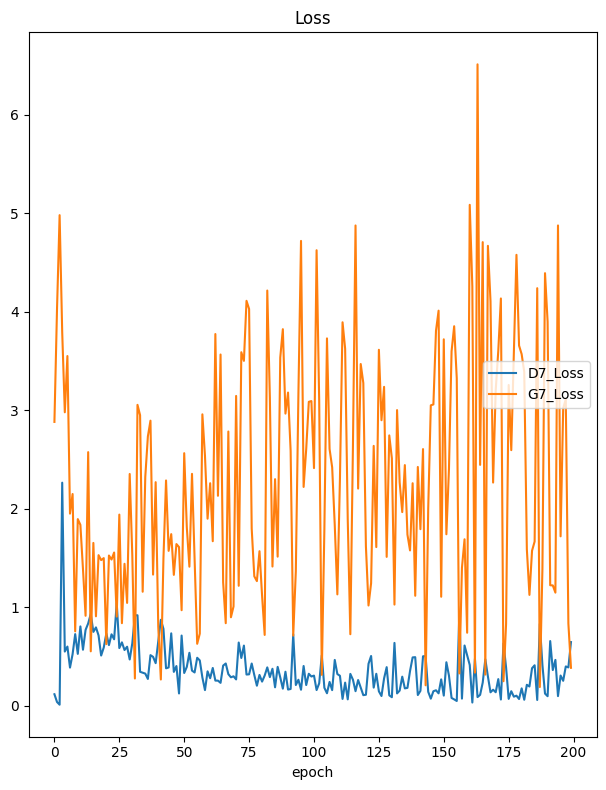

Loss
	D7_Loss          	 (min:    0.010, max:    2.264, cur:    0.646)
	G7_Loss          	 (min:    0.189, max:    6.512, cur:    0.385)


In [15]:
set_seed(0)
n_epoch = 200
# Assuming livelossplot is installed and imported if you plan to use it
# from livelossplot import PlotLosses

groups = {'Loss': ['D7_Loss', 'G7_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch + 1):
    D7_losses, G7_losses = [], []
    logs = {}

    for batch_idx, x in enumerate(dataloader):
        # Handling the case for the last batch which might be smaller
        current_batch_size = x.size(0)

        # Update the discriminator
        D7_loss = D7_train(x)
        D7_losses.append(D7_loss)

        # Update the generator
        G7_loss = G7_train(current_batch_size)  # Pass the current batch size to G_train
        G7_losses.append(G7_loss)

        # Update logs for livelossplot, if used
        logs['D7_Loss'] = D7_loss
        logs['G7_Loss'] = G7_loss

    liveloss.update(logs)
    liveloss.draw()

    # Save model checkpoints
    if epoch % 20 == 0:
        torch.save(G7.state_dict(), f"./LectureModel7_{epoch:03d}.pth")

In the hyperparemeter tuning notebook, we see that some models converge but display worse images. We chose this because of the images, and not because of the loss values.

## Generate 300 new samples with your trained network

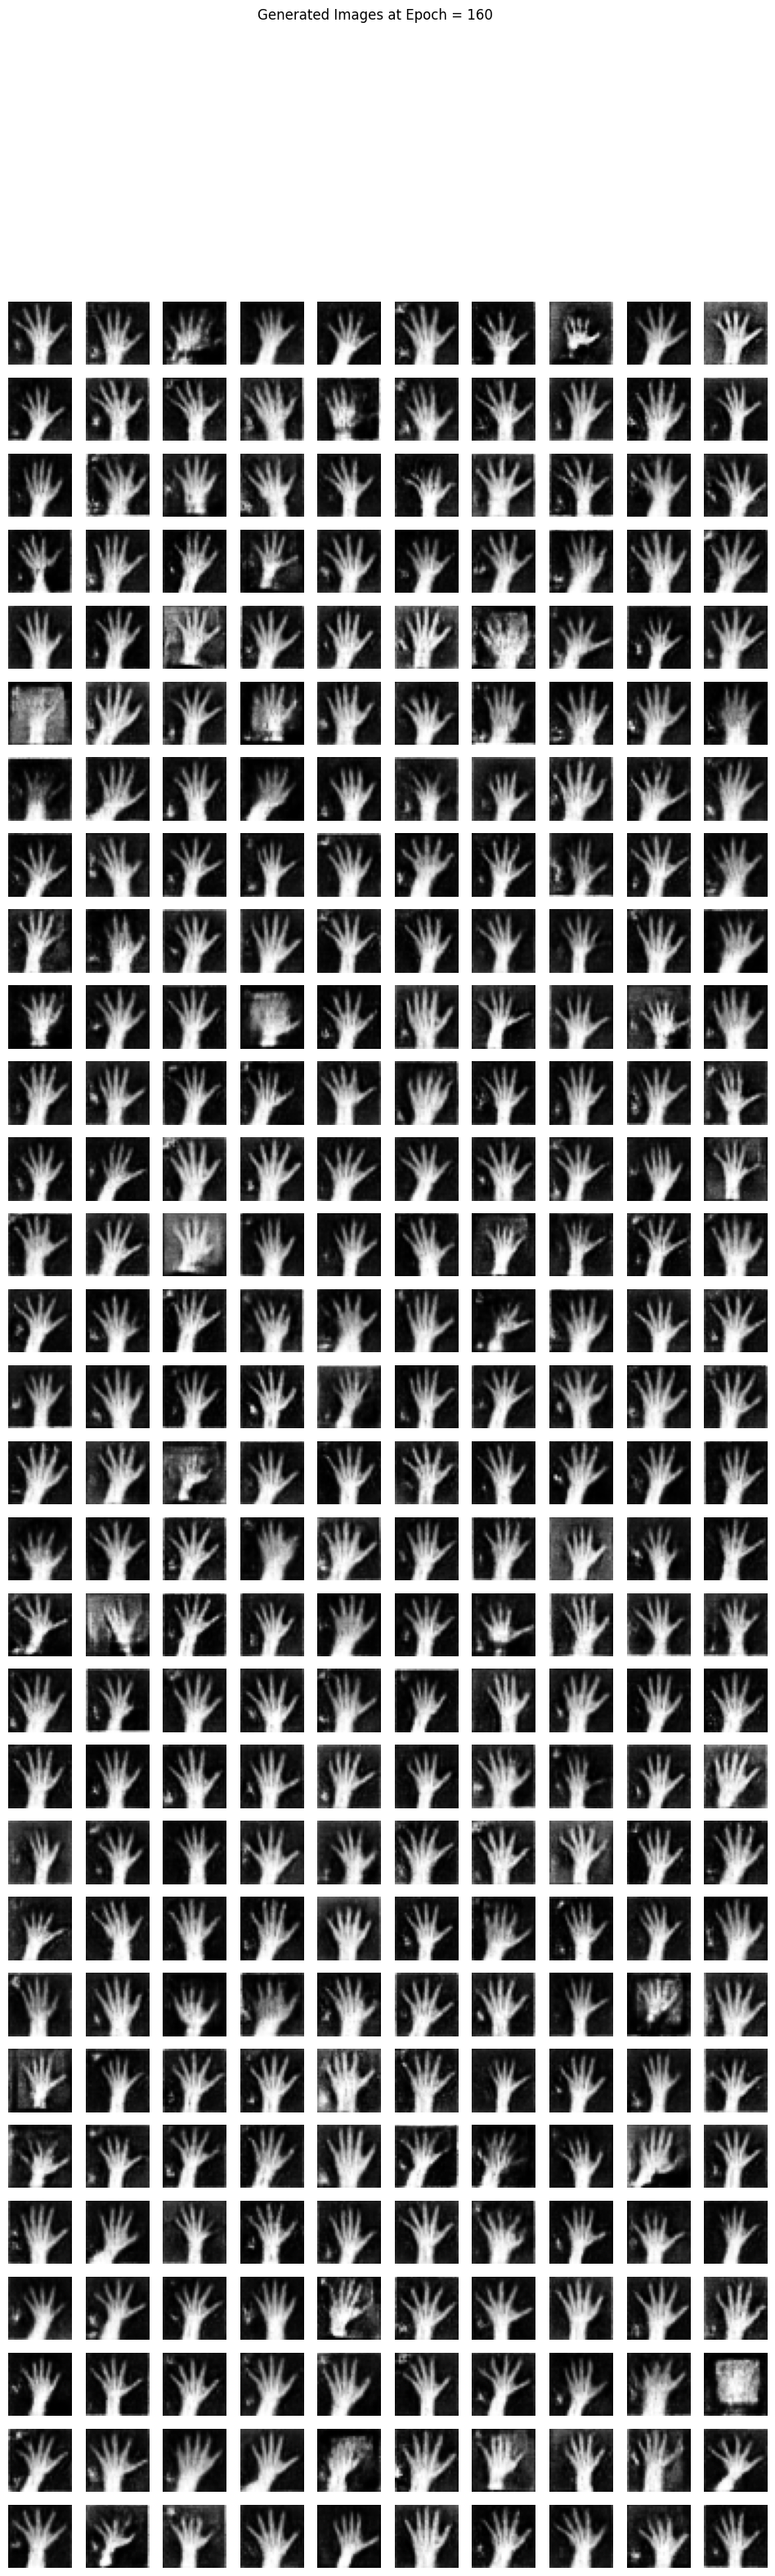

In [22]:
set_seed(0)

epoch = 160  # Load the model after 20 epochs
G7.load_state_dict(torch.load("./LectureModel7_{:03d}.pth".format(epoch)))
G7.eval()  # Set the generator to evaluation mode

# Initialize an empty list to hold generated images
generated_images = []

# Generate 300 samples in batches of 100
for _ in range(3):  # Loop three times
    with torch.no_grad():
        test_z = torch.randn(100, z_dim, 1, 1).to(device)  # Generate a batch of 100 latent vectors
        generated = G7(test_z)  # Generate a batch of 100 images
        generated_images.append(generated)

# Concatenate the generated images to form a single tensor
generated_images = torch.cat(generated_images, dim=0)

# Visualize the generated images
fig, axarr = plt.subplots(30, 10, figsize=(12, 36))  # Adjust the subplot dimensions for 300 images
for ax, img in zip(axarr.flatten(), generated_images.view(generated_images.size(0), 32, 32).cpu()):
    ax.imshow(img, cmap="gray")
    ax.axis('off')  # Hide the axes
plt.suptitle('Generated Images at Epoch = {:03d}'.format(epoch))
plt.show()


## Save the 300 generated samples as `.jpeg` files
The format of the saved samples should be `.jpeg`, and the names of the files should be:
- `yourusername_VAE001.jpeg`, `yourusername_VAE002.jpeg`, ... , `yourusername_VAE300.jpeg`

or

- - `yourusername_GAN001.jpeg`, `yourusername_GAN002.jpeg`, ... , `yourusername_GAN300.jpeg`

You can save your samples in your Google Drive or your local machine and then copy them to the repo where you will submit the answer.

In [20]:
image_folder = "gdrive/My Drive/dlmodule-coursework-1-edsml-jv323/DCGAN/generated_images_epoch_{:03d}".format(160)
os.makedirs(image_folder, exist_ok=True)

for i, img in enumerate(generated_images):

    img = img.view(32, 32).cpu()


    img = transforms.ToPILImage()(img)


    img.save(os.path.join(image_folder, "edsml-jv323_{:03d}.jpg".format(i)))